In [31]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
df = pd.read_csv('/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [7]:
def check_df(dataframe, head=5):
  print("##################### Shape #####################")
  print(dataframe.shape)
  print("##################### Types #####################")
  print(dataframe.dtypes)
  print("##################### Head #####################")
  print(dataframe.head(head))
  print("##################### Tail #####################")
  print(dataframe.tail(head))
  print("##################### NA #####################")
  print(dataframe.isnull().sum())

In [8]:
check_df(df)

##################### Shape #####################
(2416, 7)
##################### Types #####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
##################### Head #####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
##################### Tail #####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [11]:
tesla_df= df[["Date", "Close"]]
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [12]:
print("min tarih", tesla_df.Date.min())
print("max tarih", tesla_df.Date.max())

min tarih 2010-06-29 00:00:00
max tarih 2020-02-03 00:00:00


In [13]:
tesla_df.index=tesla_df.Date
tesla_df.drop("Date", axis=1, inplace=True)

In [15]:
tesla_df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


In [16]:
result_df = tesla_df.copy()

In [17]:
#numpy array yapma:
tesla_df=tesla_df.values

In [18]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [19]:
tesla_df=tesla_df.astype("float32")

In [20]:
#train test ayrımı
def split_data(dataframe, test_size):
  pos= int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:pos]
  test = dataframe[pos:]
  return train, test, pos

In [21]:
train, test, pos = split_data(tesla_df, 0.2)

In [22]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [23]:
scaler_train = MinMaxScaler(feature_range=(0,1))
train= scaler_train.fit_transform(train)
scaler_test = MinMaxScaler(feature_range=(0,1))
test= scaler_test.fit_transform(test)

In [24]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [26]:
#feature üretme - 20 gün öncesini baz alıcaz. yani önceki 20 gün column olarak eklenecek
def create_features(data,lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i, 0])
    Y.append(data[i, 0])
  return np.array(X), np.array(Y)

In [27]:
lookback=20
X_train, y_train = create_features(train, lookback)
X_test, y_test = create_features(test, lookback)

In [28]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1913, 20) (1913,)
(463, 20) (463,)


In [29]:
X_train = np.reshape(X_train, (X_train.shape[0],1,  X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,  X_test.shape[1]))
y_train =y_train.reshape(-1,1)
y_test =y_test.reshape(-1,1)

In [30]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1)
(463, 1, 20) (463, 1)


In [32]:
model = Sequential()
model.add(LSTM(units=50, activation="relu", input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [35]:
callbacks= [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
            ModelCheckpoint(filepath="best_model.keras", monitor="val_loss",
                            save_best_only=True, save_weights_only=False, verbose=1)]

In [37]:
history= model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          callbacks=callbacks,
          shuffle=False,
          batch_size=20,
          epochs=100)

Epoch 1/100
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 1: val_loss improved from inf to 0.00366, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 2/100
81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 2: val_loss improved from 0.00366 to 0.00341, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 3/100
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 3: val_loss improved from 0.00341 to 0.00316, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 4/100
78/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 4: val_loss improved from 0.00316 to 0.00298, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/100
77/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 5: val_loss improved from 0.00298 to

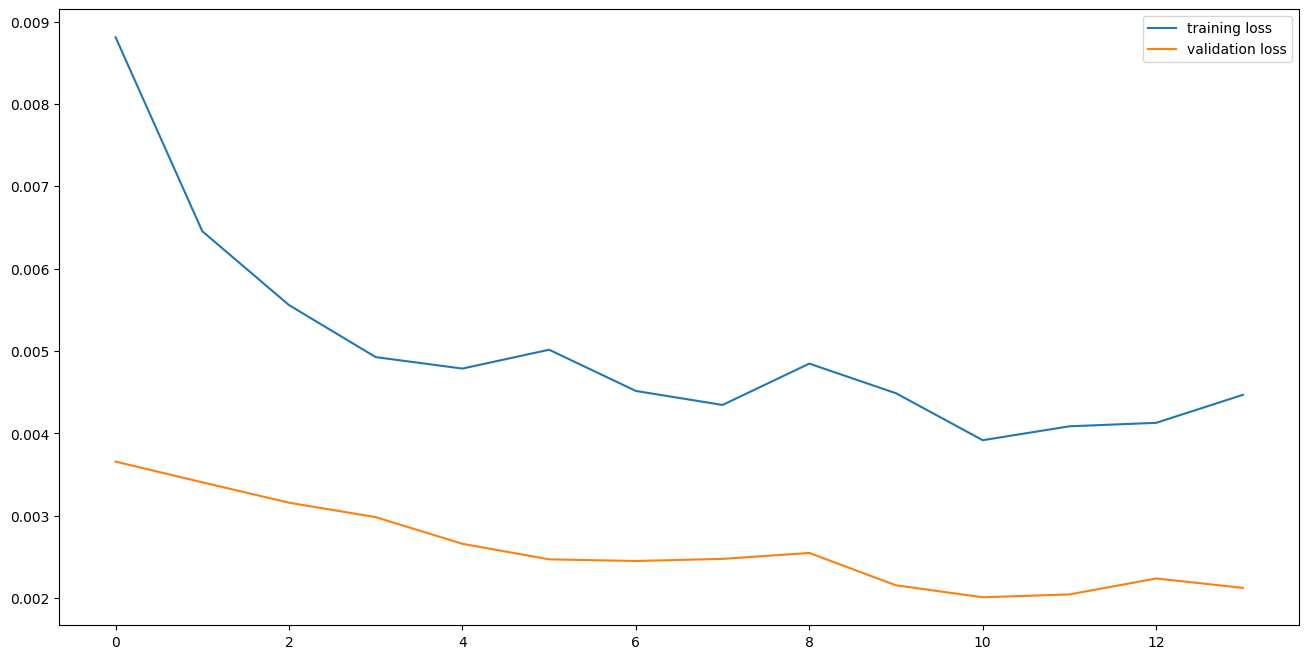

In [38]:
plt.figure(figsize=(16,8))
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()

In [40]:
loss = model.evaluate(X_test, y_test, batch_size=20)
print("Test Loss:", loss)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016     
Test Loss: 0.002124773571267724


In [41]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [42]:
#daha doğru bir hata değeri almak için
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [43]:
y_train= scaler_train.inverse_transform(y_train)
y_test= scaler_test.inverse_transform(y_test)

In [44]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [45]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [46]:
print("train rmse:", train_rmse)
print("test rmse:", test_rmse)

train rmse: 13.462524
test rmse: 27.704643
